In [1]:
!pip install sagemaker amazon-textract-textractor[pdfium]==1.8.3 --quiet

In [2]:
import os
# adjust profile or region if required
# os.environ["AWS_PROFILE"] = "your_profile"
# os.environ["AWS_DEFAULT_REGION"] = "us-west-2"

In [3]:
import sagemaker

# Get the SageMaker session and default bucket
sagemaker_session = sagemaker.Session()
default_bucket = sagemaker_session.default_bucket()
print(f"Default sagemaker bucket: {default_bucket}")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Default sagemaker bucket: sagemaker-us-west-2-557690596620


In [4]:
#download a pdf from a url if required
sample_paper_url = "https://arxiv.org/pdf/2404.10630"
!wget -O ./data/my_document.pdf {sample_paper_url} --no-check-certificate

--2024-08-27 11:07:36--  https://arxiv.org/pdf/2404.10630
Resolving arxiv.org (arxiv.org)... 151.101.67.42, 151.101.3.42, 151.101.195.42, ...
Connecting to arxiv.org (arxiv.org)|151.101.67.42|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 1362915 (1.3M) [application/pdf]
Saving to: ‘./data/my_document.pdf’

./data/my_document. 100%[===================>]   1.30M  --.-KB/s    in 0.1s    

2024-08-27 11:07:36 (11.5 MB/s) - ‘./data/my_document.pdf’ saved [1362915/1362915]



In [5]:
# copy data folder with sample pdf files to S3
!aws s3 sync ./data s3://{default_bucket}/data

In [6]:
document = "data/paper-llm-training-sample.pdf"
#document = "data/my_document.pdf"
document_s3_url = f"s3://{default_bucket}/{document}"

## Using interactive Textract Demo for layout analysis

Try the [interactive Textract Demo for layout analysis](https://console.aws.amazon.com/textract/home?#/demo) in the AWS Console.


## Using Amazon Textract Textractor Library

In [7]:
from textractor import Textractor
from textractor.data.constants import TextractFeatures
from textractor.data.text_linearization_config import TextLinearizationConfig

extractor = Textractor()
document = extractor.start_document_analysis(
    document_s3_url,
    features=[TextractFeatures.LAYOUT, TextractFeatures.FORMS, TextractFeatures.TABLES],
    save_image=True,
)

In [8]:
document

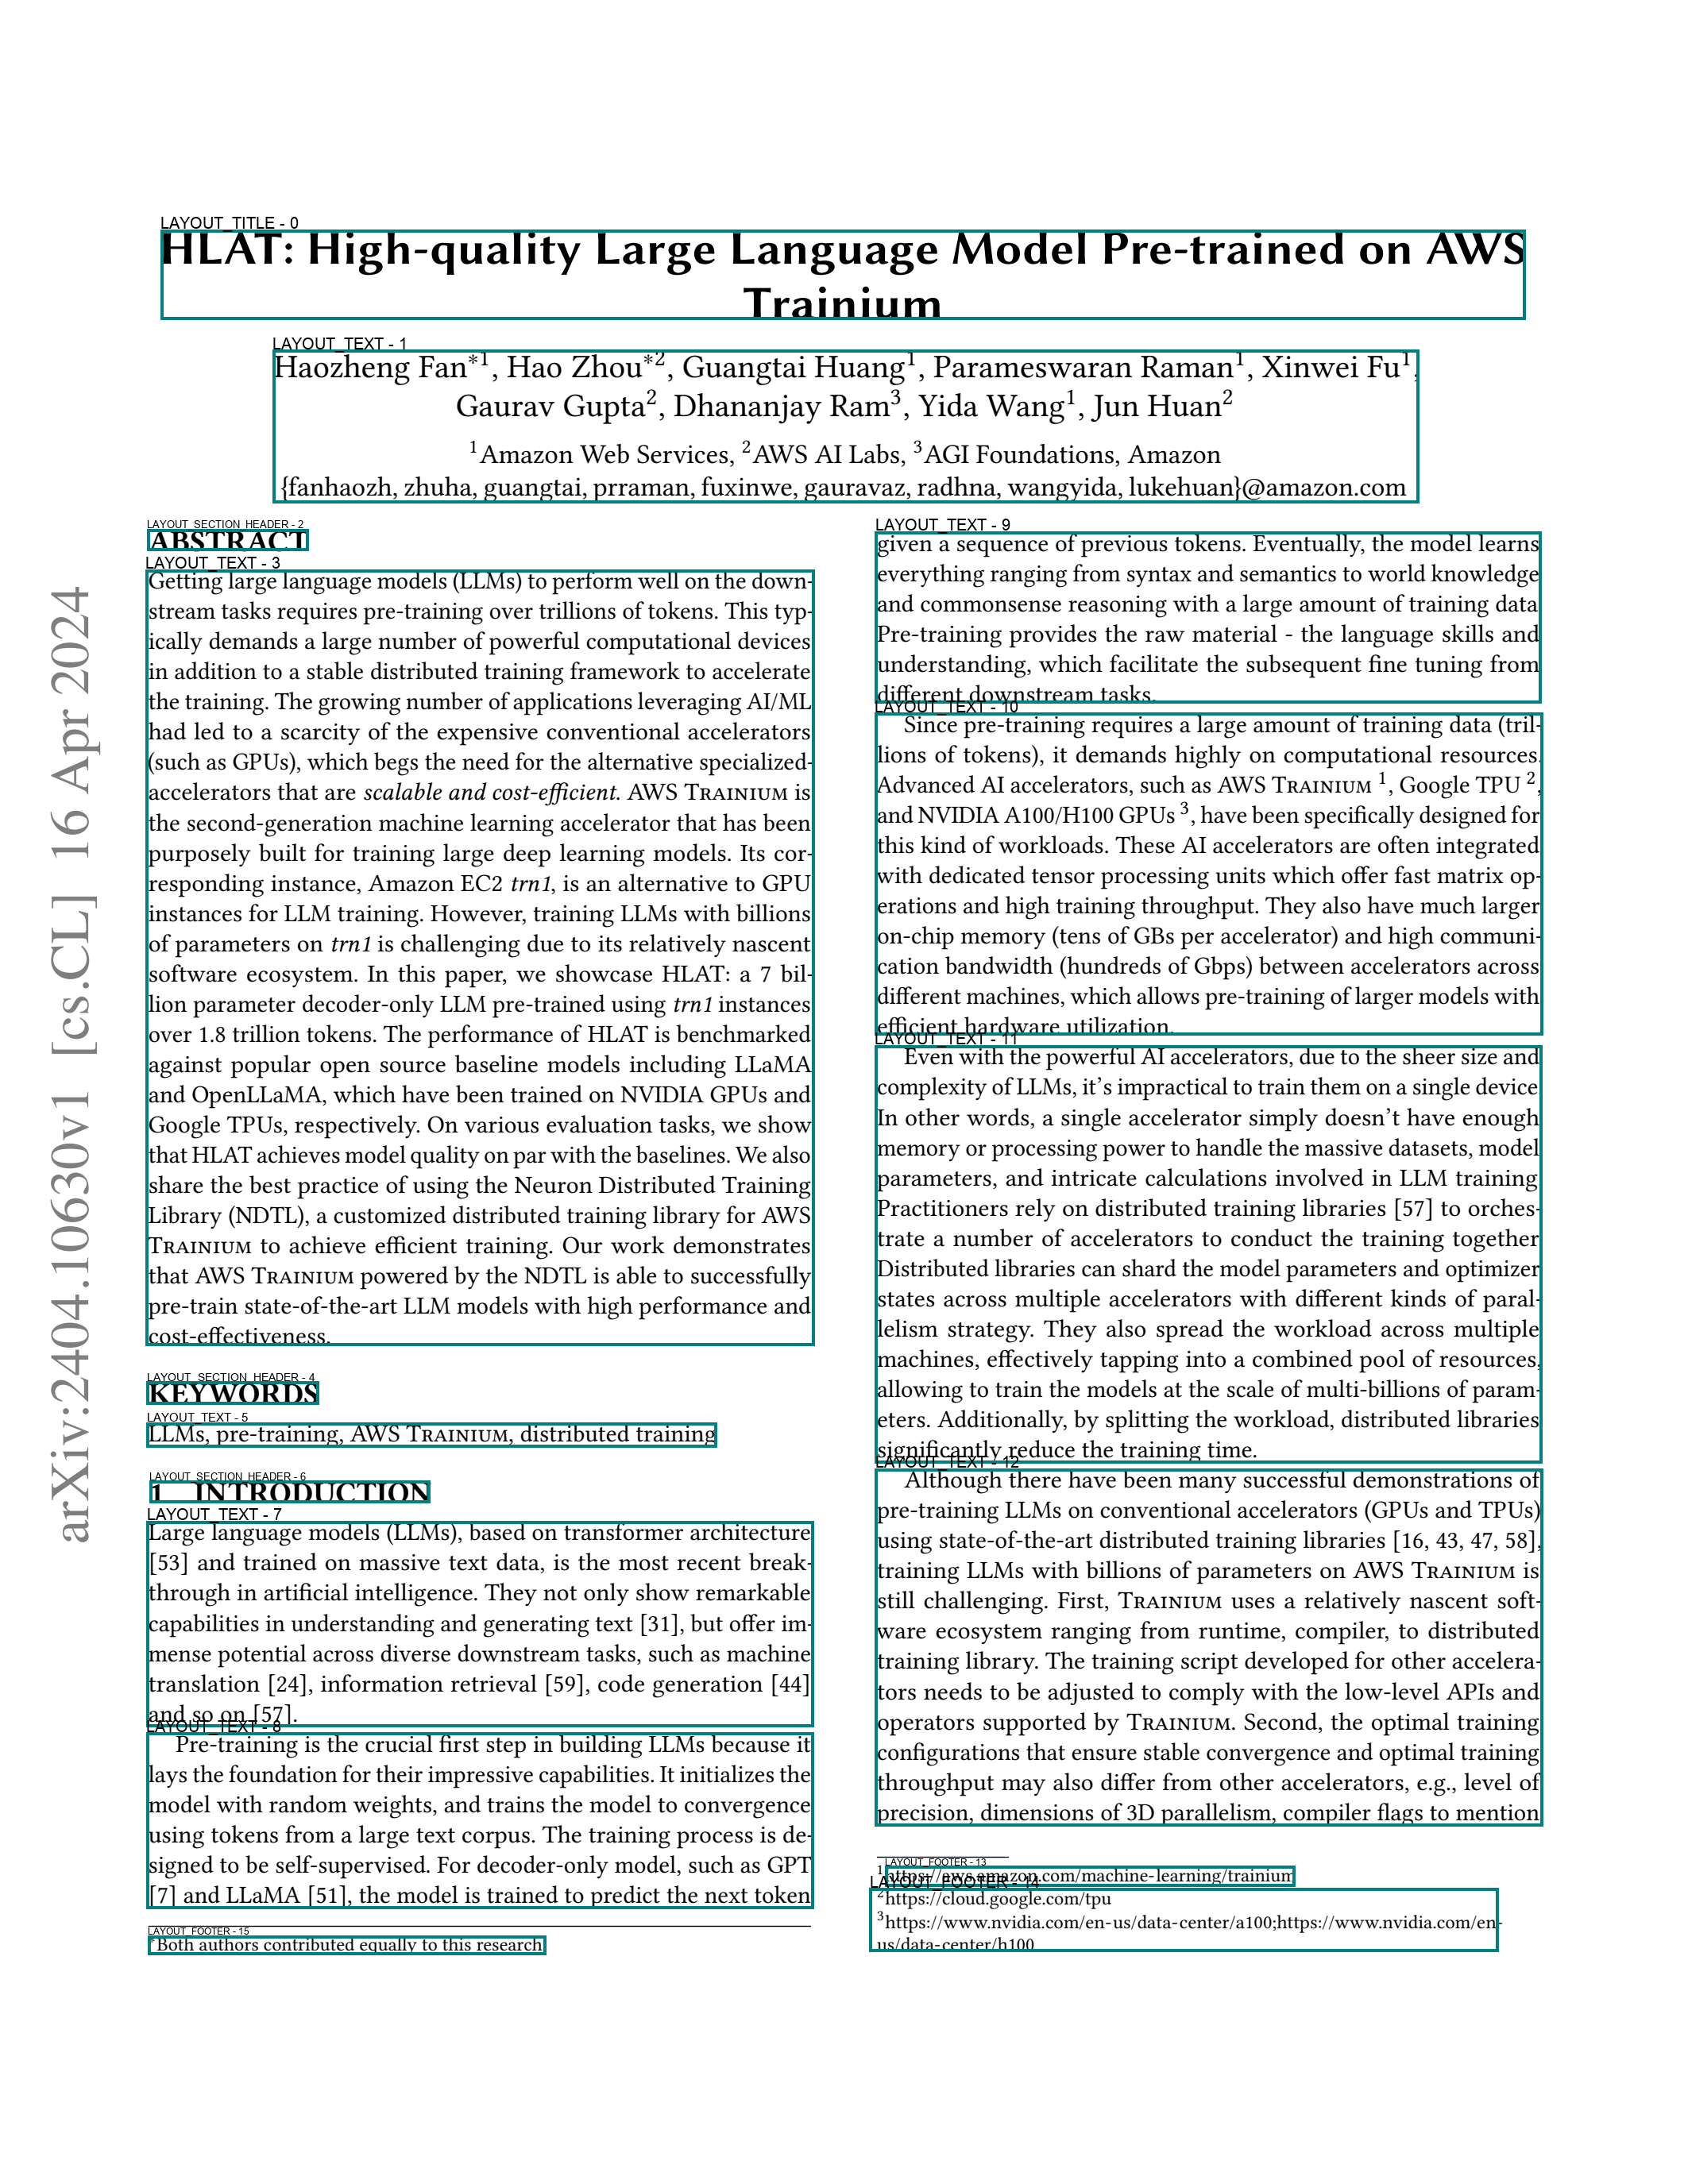

In [9]:
# visualize first page of document
document.pages[0].layouts.visualize(with_text=True, with_words=False).convert("RGB")

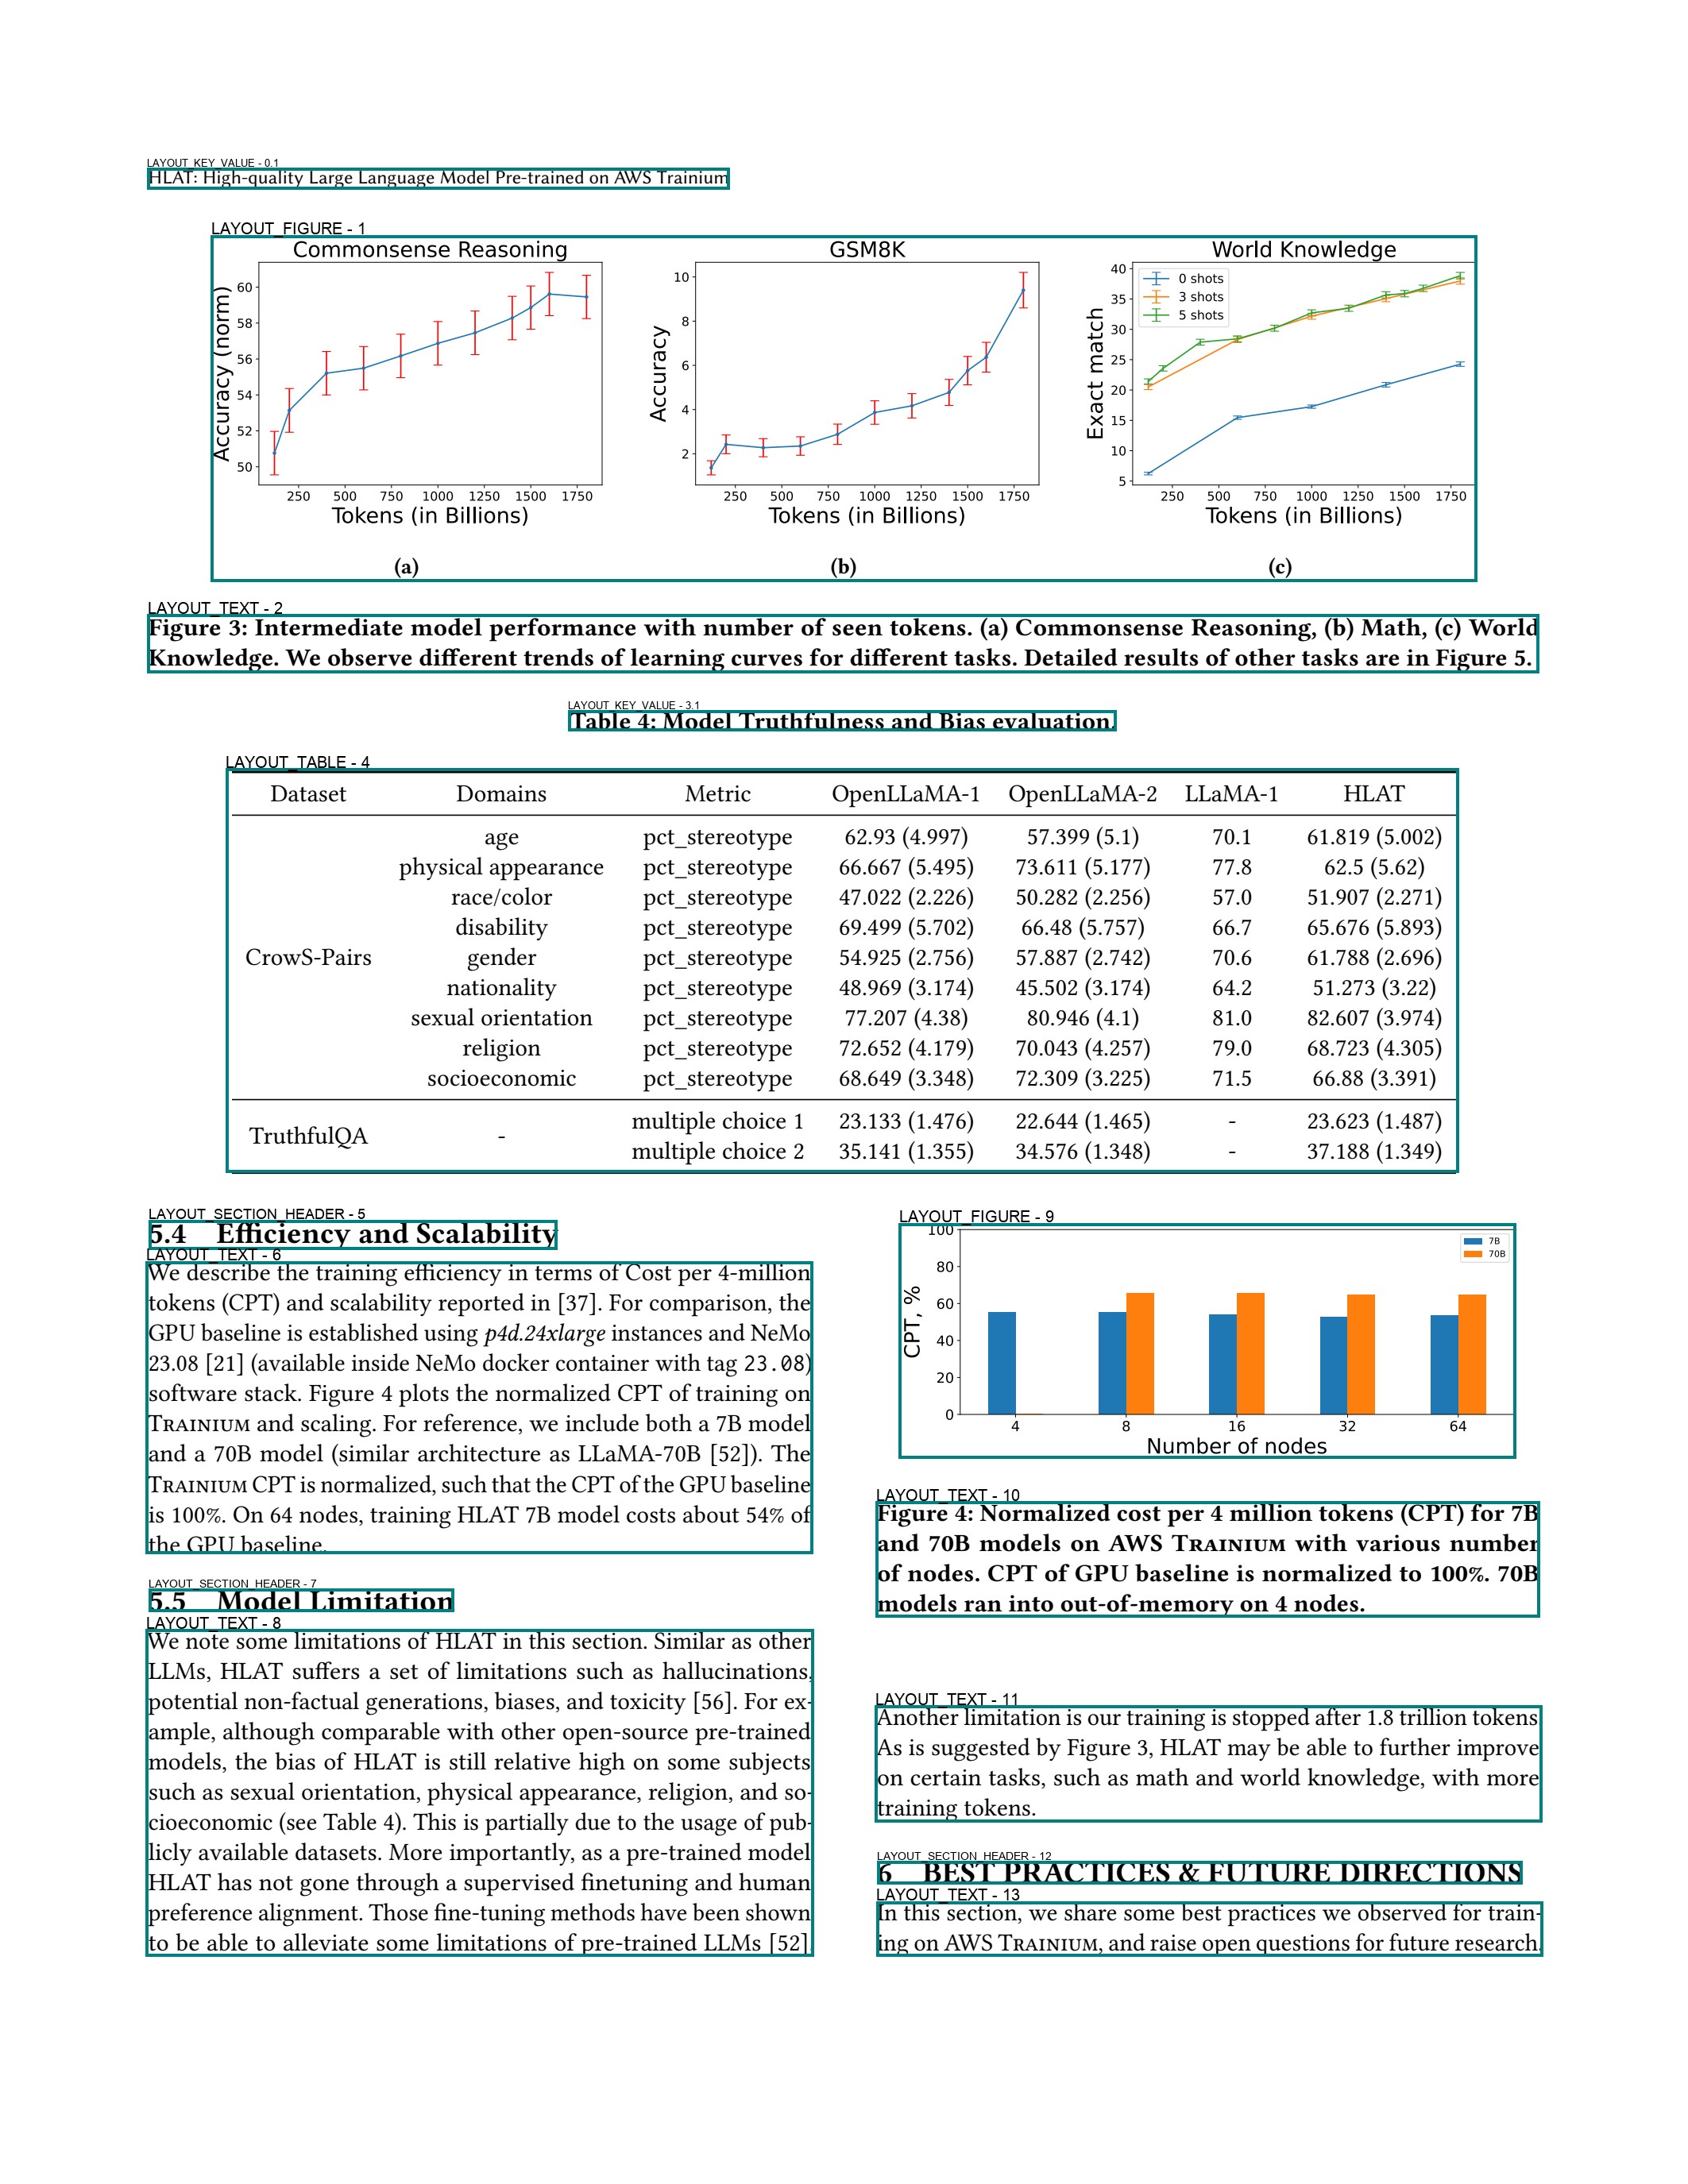

In [ ]:
# visualize the layout of another page
document.pages[6].layouts.visualize(with_text=True, with_words=False).convert("RGB")

In [11]:
# Show the table as proper pandas DataFrame with headers etc.
document.tables[2].to_pandas(use_columns=True)

Task  Shots                  Metric      OpenLLaMA-1   \
0                   MMLU      5                accuracy   30.552 (3.432)    
1                    BBH      3   multiple choice grade   35.535 (1.864)    
2  Commonsense Reasoning      0                accuracy   55.587 (1.203)    
3                             0         accuracy (norm)   58.411 (1.201)    
4        World Knowledge      5             exact match   38.942 (0.532)    
5  Reading Comprehension      0                accuracy   70.459 (0.798)    
6                   Math      8                accuracy     5.08 (0.605)    
7                   Code      0                  pass@1             4.77    
8                             0                 pass@10            12.83    
9                             0                pass@100            23.78    

      OpenLLaMA-2  LLaMA-1  LLaMA-2             HLAT   
0  41.075 (3.611)     35.1     45.3   41.318 (3.602)   
1  35.502 (1.861)     30.3     32.6   36.565 (1.845)   
2  56.893 (1.195)        -        -   56.152 (1.194)   
3   61.262 (1.19)    67.3*    67.5*   59.455 (1.206)   
4   37.023 (0.52)    46.2*    48.9*   38.846 (0.534)   
5  72.416 (0.782)     76.5     77.4   72.508 (0.781)   
6   5.231 (0.613)     11.0     14.6    9.401 (0.804)   
7            9.06     10.5     12.8             7.62   
8           23.58        -        -            19.83   
9           40.24     36.5     45.6            34.15

## Converting to HTML
<a id='convert_to_html'></a>

In [12]:
# helper to limit the height in our view
def wrapped_html(html):
    full_html = f"""
    <div style="max-height: 500px; overflow-y: auto;">
        {html}
    </div>
    """
    return full_html

In [13]:
from IPython.display import display, HTML

html= document.to_html()
display(HTML(wrapped_html(html)))

## Converting to Markdown
<a id='convert_to_md'></a>

In [14]:
from IPython.display import display, Markdown
from ipywidgets import widgets, Layout

def display_markdown_with_max_height(markdown_text, max_height='300px'):
    html_content = f"""
    <div style="max-height: {max_height}; overflow-y: auto;">    
    <pre style="margin: 0;">{Markdown(markdown_text).data}</pre>    
    </div>
    """
    display(HTML(html_content))

long_markdown = document.to_markdown()
# display_markdown_with_max_height(long_markdown, max_height='300px')

#display(Markdown(document.pages[6].to_markdown()))
display(Markdown(document.pages[0].to_markdown()))

#  HLAT: High-quality Large Language Model Pre-trained on AWS Trainium 

Haozheng Fan*1, Hao Zhou*2 Guangtai Huang1 Parameswaran Raman¹, Xinwei Fu¹, Gaurav Gupta², Dhananjay Ram³, Yida Wang1, Jun Huan2 Superscript(1)Amazon Web Services, 2 AWS AI Labs, 3 AGI Foundations, Amazon {fanhaozh, zhuha, guangtai, prraman, fuxinwe, gauravaz, radhna, wangyida, lukehuan}@amazon.com 

## ABSTRACT 

Getting large language models (LLMs) to perform well on the down- stream tasks requires pre-training over trillions of tokens. This typ- ically demands a large number of powerful computational devices in addition to a stable distributed training framework to accelerate the training. The growing number of applications leveraging AI/ML had led to a scarcity of the expensive conventional accelerators (such as GPUs), which begs the need for the alternative specialized- accelerators that are scalable and cost-efficient. AWS TRAINIUM is the second-generation machine learning accelerator that has been purposely built for training large deep learning models. Its cor- responding instance, Amazon EC2 trn1, is an alternative to GPU instances for LLM training. However, training LLMs with billions of parameters on trn1 is challenging due to its relatively nascent software ecosystem. In this paper, we showcase HLAT: a 7 bil- lion parameter decoder-only LLM pre-trained using trn1 instances over 1.8 trillion tokens. The performance of HLAT is benchmarked against popular open source baseline models including LLaMA and OpenLLaMA, which have been trained on NVIDIA GPUs and Google TPUs, respectively. On various evaluation tasks, we show that HLAT achieves model quality on par with the baselines. We also share the best practice of using the Neuron Distributed Training Library (NDTL), a customized distributed training library for AWS TRAINIUM to achieve efficient training. Our work demonstrates that AWS TRAINIUM powered by the NDTL is able to successfully pre-train state-of-the-art LLM models with high performance and cost-effectiveness. 

## KEYWORDS 

LLMs, pre-training, AWS TRAINIUM, distributed training 

## 1 INTRODUCTION 

Large language models (LLMs), based on transformer architecture [53] and trained on massive text data, is the most recent break- through in artificial intelligence. They not only show remarkable capabilities in understanding and generating text [31], but offer im- mense potential across diverse downstream tasks, such as machine translation [24], information retrieval [59], code generation [44] and so on [57]. 

Pre-training is the crucial first step in building LLMs because it lays the foundation for their impressive capabilities. It initializes the model with random weights, and trains the model to convergence using tokens from a large text corpus. The training process is de- signed to be self-supervised. For decoder-only model, such as GPT and LLaMA [51], the model is trained to predict the next token [7] 

given a sequence of previous tokens. Eventually, the model learns everything ranging from syntax and semantics to world knowledge and commonsense reasoning with a large amount of training data. Pre-training provides the raw material - the language skills and understanding, which facilitate the subsequent fine tuning from different downstream tasks. 

Since pre-training requires a large amount of training data (tril- lions of tokens), it demands highly on computational resources. Advanced AI accelerators, such as AWS TRAINIUM Google TPU and NVIDIA A100/H100 GPUs have been specifically designed for this kind of workloads. These AI accelerators are often integrated with dedicated tensor processing units which offer fast matrix op- erations and high training throughput. They also have much larger on-chip memory (tens of GBs per accelerator) and high communi- cation bandwidth (hundreds of Gbps) between accelerators across different machines, which allows pre-training of larger models with efficient hardware utilization. 

Even with the powerful AI accelerators, due to the sheer size and complexity of LLMs, it's impractical to train them on a single device. In other words, a single accelerator simply doesn't have enough memory or processing power to handle the massive datasets, model parameters, and intricate calculations involved in LLM training. Practitioners rely on distributed training libraries [57] to orches- trate a number of accelerators to conduct the training together. Distributed libraries can shard the model parameters and optimizer states across multiple accelerators with different kinds of paral- lelism strategy. They also spread the workload across multiple machines, effectively tapping into a combined pool of resources, allowing to train the models at the scale of multi-billions of param- eters. Additionally, by splitting the workload, distributed libraries significantly reduce the training time. 

Although there have been many successful demonstrations of pre-training LLMs on conventional accelerators (GPUs and TPUs) using state-of-the-art distributed training libraries [16, 43, 47, 58], training LLMs with billions of parameters on AWS TRAINIUM is still challenging. First, TRAINIUM uses a relatively nascent soft- ware ecosystem ranging from runtime, compiler, to distributed training library. The training script developed for other accelera- tors needs to be adjusted to comply with the low-level APIs and operators supported by TRAINIUM. Second, the optimal training configurations that ensure stable convergence and optimal training throughput may also differ from other accelerators, e.g., level of precision, dimensions of 3D parallelism, compiler flags to mention 

https://aws.amazon.com/machine-learning/trainium


'https://cloud.google.com/tpu
 https://www.nvidia.com/en-us/data-center/a100;https://www.nvidia.com/en
 us/data-center/h100


*Both authors contributed equally to this research.


## Layout-aware Chunking <a id='layout_chunking'></a>

The goal is to consider the semantic structure of the document to improve information retrieval.
Each text block is combined with its previous title and section header. In addition to that tables are formatted properly using markdown and figures and diagrams are additionally extend with description of what is contained on theim.

The main steps are
* Linearize each unit using the semantic layout information.
* For each chunk (paragraph): Add relevant layout metadata to each chunk like, page_number, bounding_box, title, section, etc.
* For Figures: Extend them for semantic indexing
  * Option 1: Describe figures, images, diagrams using e.g. Claude 3 vision, and add this description as textual metadata field or as separate chunk
  * Option 2: Embed figures, images, diagrams directly using [Titan Image Embeddings](https://docs.aws.amazon.com/bedrock/latest/userguide/titan-multiemb-models.html)

The result is an ordered list of chunks with metadata and all semantic layout information from the document to improve information retrieval.
The metadata can be used for automatic filtering on top of RAG. For example when a user asks "Show me relevant figures that compare different language model pretrainings", the LLM can also restrict the vector search on chunks which are related to figures only.


### Create dataframe with chunks and raw metadata

In [15]:
import pandas as pd

rows = []
for layout in document.layouts:        
    row = {}    
    row["layout_type"] = layout.layout_type
    row["page"] = layout.page
    row["confidence"] = layout.confidence
    row["reading_order"] = layout.reading_order
    row["text"] = layout.get_text()
    row["words"] = layout.words
    # row["bbox"] = layout.bbox
    row["id"] = layout.id
    row.update(layout.bbox.__dict__)
    row["layout"] = layout
    row["raw_object"] = layout.raw_object
        
    del row["spatial_object"]    
    rows.append(row)    

df = pd.DataFrame(rows)
df

layout_type  page  confidence  reading_order  \
0             LAYOUT_TITLE     1    0.713867            0.0   
1              LAYOUT_TEXT     1    0.490234            1.0   
2    LAYOUT_SECTION_HEADER     1    0.969238            2.0   
3              LAYOUT_TEXT     1    0.965820            3.0   
4    LAYOUT_SECTION_HEADER     1    0.835449            4.0   
..                     ...   ...         ...            ...   
140  LAYOUT_SECTION_HEADER    10    0.940918           33.0   
141            LAYOUT_TEXT    10    0.975586           34.0   
142  LAYOUT_SECTION_HEADER    10    0.923828           35.0   
143            LAYOUT_TEXT    10    0.966797           36.0   
144          LAYOUT_FOOTER    10    0.623535           37.0   

                                                  text  \
0     HLAT: High-quality Large Language Model Pre-t...   
1    Haozheng Fan*1, Hao Zhou*2 Guangtai Huang1 Par...   
2                                            ABSTRACT    
3    Getting large language models (LLMs) to perfor...   
4                                            KEYWORDS    
..                                                 ...   
140  B EVALUATION RESULTS ON INTERMEDIATE CHECKPOINTS    
141  In Table 6 we list the evaluation results of H...   
142                    C NEURON NEMO MEGATORN PACKAGE    
143  We also experimented on AWS Neuron Nemo Megatr...   
144  10 https://awsdocs-neuron.readthedocs-hosted.c...   

                                                 words  \
0    [HLAT:, High-quality, Large, Language, Model, ...   
1    [Haozheng, Fan*1,, Hao, Zhou*2, Guangtai, Huan...   
2                                           [ABSTRACT]   
3    [Getting, large, language, models, (LLMs), to,...   
4                                           [KEYWORDS]   
..                                                 ...   
140  [B, EVALUATION, RESULTS, ON, INTERMEDIATE, CHE...   
141  [In, Table, 6, we, list, the, evaluation, resu...   
142               [C, NEURON, NEMO, MEGATORN, PACKAGE]   
143  [We, also, experimented, on, AWS, Neuron, Nemo...   
144  [10, https://awsdocs-neuron.readthedocs-hosted...   

                                       id     width    height         x  \
0    dea58017-d3b0-4a19-ad84-bcde59a18b9a  0.808515  0.041284  0.095165   
1    3c864def-1bf6-40a5-9bfc-793c657dceca  0.679195  0.070040  0.161424   
2    f3e42997-554e-4a7a-9181-56dd6d5f6da4  0.095758  0.010076  0.087245   
3    5cde2a6a-8e58-4bb5-b3cc-061ef7be690f  0.396307  0.355211  0.086220   
4    ff19d00a-0c57-4adf-a6bc-dccd821f8da7  0.101833  0.010524  0.086953   
..                                    ...       ...       ...       ...   
140  e2454f8d-2390-4e4d-84ae-d681c1b892dd  0.392659  0.026649  0.519043   
141  05497635-5ca7-4e91-b1a3-c701a475b96b  0.395610  0.053221  0.518692   
142  99b103e3-7cc6-49c4-93e7-5f390cce24e0  0.359845  0.010474  0.519382   
143  bebd9f25-b926-45d6-af2e-b7d2d1808aef  0.395856  0.081973  0.518186   
144  d7c8233f-6784-4124-9e99-1e6aefb9eeed  0.362837  0.020511  0.518741   

            y                                             layout  \
0    0.105198  <textractor.entities.layout.Layout object at 0...   
1    0.160205  <textractor.entities.layout.Layout object at 0...   
2    0.242227  <textractor.entities.layout.Layout object at 0...   
3    0.260800  <textractor.entities.layout.Layout object at 0...   
4    0.632657  <textractor.entities.layout.Layout object at 0...   
..        ...                                                ...   
140  0.399944  <textractor.entities.layout.Layout object at 0...   
141  0.434796  <textractor.entities.layout.Layout object at 0...   
142  0.501512  <textractor.entities.layout.Layout object at 0...   
143  0.518634  <textractor.entities.layout.Layout object at 0...   
144  0.874469  <textractor.entities.layout.Layout object at 0...   

                                            raw_object  
0    {'BlockType': 'LAYOUT_TITLE', 'Confidence': 71...  
1    {'BlockType': 'LAYOUT_TEXT'

### Forward fill chunks with metadata (LAYOUT_TITLE, LAYOUT_SECTION_HEADER)

In [16]:
# add header/section columns and rolling fill the chunks with the upper value of header/section
def forward_fill_column(df, col_name, header_value):
    # Step 1: Create a boolean mask for LAYOUT_HEADER rows
    header_mask = df[col_name] == header_value
    # Step 2: Create a new column 'header_value' initialized with NaN
    df[header_value] = pd.NA
    # Step 3: Set value for mask
    df.loc[header_mask, header_value] = df.loc[header_mask, 'text']
    # Step 4: Forward fill the header values
    df[header_value] = df[header_value].ffill()    
    # Step 5: Set 'header_value' to NaN for LAYOUT_HEADER rows
    df.loc[header_mask, header_value] = pd.NA
    return df

# df = forward_fill_column(df, "layout_type","LAYOUT_HEADER")
df = forward_fill_column(df, "layout_type","LAYOUT_TITLE")
df = forward_fill_column(df, "layout_type","LAYOUT_SECTION_HEADER")
df[["layout_type", "LAYOUT_TITLE", "LAYOUT_SECTION_HEADER", "page","text"]].head(30)

layout_type                                       LAYOUT_TITLE  \
0            LAYOUT_TITLE                                               <NA>   
1             LAYOUT_TEXT   HLAT: High-quality Large Language Model Pre-t...   
2   LAYOUT_SECTION_HEADER   HLAT: High-quality Large Language Model Pre-t...   
3             LAYOUT_TEXT   HLAT: High-quality Large Language Model Pre-t...   
4   LAYOUT_SECTION_HEADER   HLAT: High-quality Large Language Model Pre-t...   
5             LAYOUT_TEXT   HLAT: High-quality Large Language Model Pre-t...   
6   LAYOUT_SECTION_HEADER   HLAT: High-quality Large Language Model Pre-t...   
7             LAYOUT_TEXT   HLAT: High-quality Large Language Model Pre-t...   
8             LAYOUT_TEXT   HLAT: High-quality Large Language Model Pre-t...   
9             LAYOUT_TEXT   HLAT: High-quality Large Language Model Pre-t...   
10            LAYOUT_TEXT   HLAT: High-quality Large Language Model Pre-t...   
11            LAYOUT_TEXT   HLAT: High-quality Large Language Model Pre-t...   
12            LAYOUT_TEXT   HLAT: High-quality Large Language Model Pre-t...   
13          LAYOUT_FOOTER   HLAT: High-quality Large Language Model Pre-t...   
14          LAYOUT_FOOTER   HLAT: High-quality Large Language Model Pre-t...   
15          LAYOUT_FOOTER   HLAT: High-quality Large Language Model Pre-t...   
16          LAYOUT_HEADER   HLAT: High-quality Large Language Model Pre-t...   
17            LAYOUT_TEXT   HLAT: High-quality Large Language Model Pre-t...   
18            LAYOUT_LIST   HLAT: High-quality Large Language Model Pre-t...   
19  LAYOUT_SECTION_HEADER   HLAT: High-quality Large Language Model Pre-t...   
20            LAYOUT_TEXT   HLAT: High-quality Large Language Model Pre-t...   
21            LAYOUT_TEXT   HLAT: High-quality Large Language Model Pre-t...   
22            LAYOUT_TEXT   HLAT: High-quality Large Language Model Pre-t...   
23            LAYOUT_LIST   HLAT: High-quality Large Language Model Pre-t...   
24       LAYOUT_KEY_VALUE   HLAT: High-quality Large Language Model Pre-t...   
25  LAYOUT_SECTION_HEADER   HLAT: High-quality Large Language Model Pre-t...   
26            LAYOUT_TEXT   HLAT: High-quality Large Language Model Pre-t...   
27  LAYOUT_SECTION_HEADER   HLAT: High-quality Large Language Model Pre-t...   
28            LAYOUT_TEXT   HLAT: High-quality Large Language Model Pre-t...   
29            LAYOUT_TEXT   HLAT: High-quality Large Language Model Pre-t...   

                               LAYOUT_SECTION_HEADER  page  \
0                                               <NA>     1   
1                                               <NA>     1   
2                                               <NA>     1   
3                                          ABSTRACT      1   
4                                               <NA>     1   
5                                          KEYWORDS      1   
6                                               <NA>     1   
7                                    1 INTRODUCTION      1   
8                                    1 INTRODUCTION      1   
9                                    1 INTRODUCTION      1   
10                                   1 INTRODUCTION      1   
11                                   1 INTRODUCTION      1   
12                                   1 INTRODUCTION      1   
13                                   1 INTRODUCTION      1   
14                                   1 INTRODUCTION      1   
15                                   1 INTRODUCTION      1   
16                                   1 INTRODUCTION      2   
17                                   1 INTRODUCTION      2   
18                                   1 INTRODUCTION      2   
19                                              <NA>     2   
20  2 BACKGROUND - DISTRIBUTED TRAINING ON TRAINIUM      2   
21  2 BACKGROUND - DISTRIBUTED TRAINING ON TRAINIUM      2   
22  2 BACKGROUND - DISTRIBUTED TRAINING ON TRAINIUM      2   
23  2 BACKGROUND - DISTRIBUTED TRAINING ON TR

### Visualize an example of detected and cropped figure

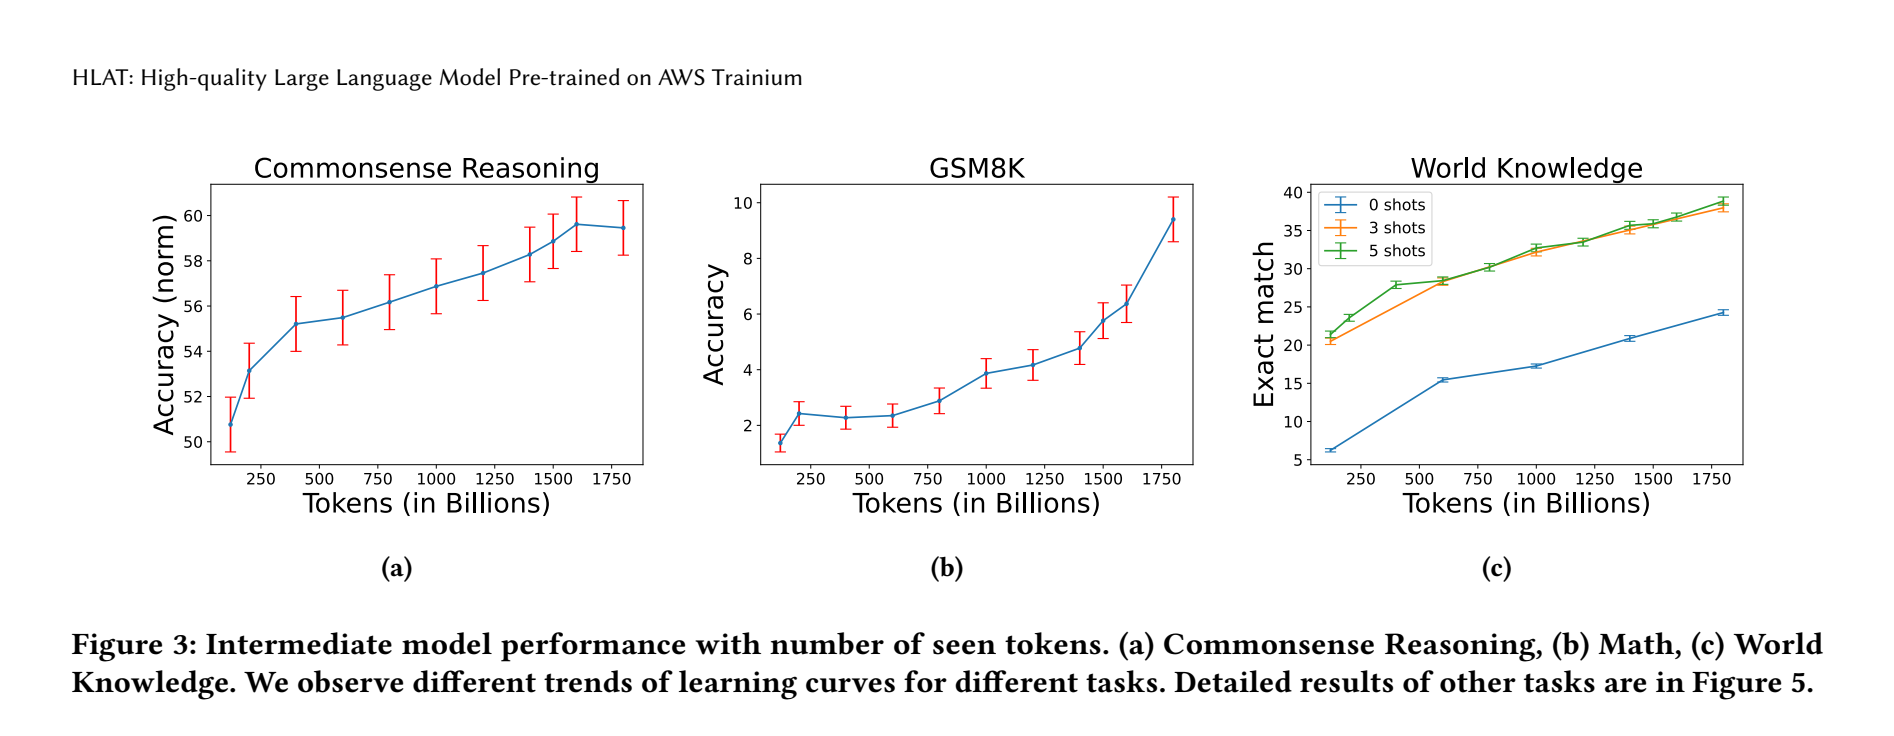

In [17]:
# visualize a detected and cropped figure
df_figures = df[df["layout_type"]=="LAYOUT_FIGURE"]
layout = df_figures["layout"].values[2]
def crop_image(layout):
    bbox = layout.bbox
    image = bbox.spatial_object.image
    img_width = image.width
    img_height = image.height
    delta = 150
    image_cut = image.crop((
        int(bbox.x*img_width)-delta, 
        int(bbox.y*img_height)-delta, 
        int((bbox.x+bbox.width)*img_width+delta), 
        int((bbox.y+bbox.height)*img_height+delta)))
    return image_cut

cropped_image = crop_image(layout)
cropped_image

### Extend figures with semantic description using Claude 3 Vision

In [18]:
# code to call Claude Vision with image and get the description of the image
import boto3
import base64
from io import BytesIO
bedrock = boto3.client('bedrock-runtime')
import boto3, json

session = boto3.Session()
bedrock = session.client(service_name='bedrock-runtime')

def encode_image(img):    
    buffered = BytesIO()
    img.save(buffered, format="PNG")
    return buffered.getvalue()

def describe_image_bedrock(img):
    image_bytes = encode_image(img)
    message_list = []        
    image_message = {
        "role": "user",
        "content": [
            { "text": "Image 1:" },
            {
                "image": {
                    "format": "png",
                    "source": {
                        "bytes": image_bytes #no base64 encoding required!
                    }
                }
            },
            { "text": "Describe the following image accurately so that it is useful for information retrieval with maximum 500 characters." }
        ],
    }
    
    message_list.append(image_message)
    
    response = bedrock.converse(
        modelId="anthropic.claude-3-sonnet-20240229-v1:0",
        messages=message_list,
        inferenceConfig={
            "maxTokens": 2000,
            "temperature": 0
        },
    )
    response_message = response['output']['message']
    return response_message

response_message = describe_image_bedrock(cropped_image)
print(json.dumps(response_message["content"], indent=4))

[
    {
        "text": "The image shows three line graphs titled (a) Commonsense Reasoning, (b) GSM8K, and (c) World Knowledge, depicting the performance of a large language model (HLAT) pre-trained on AWS Trainium across different numbers of tokens (in billions) on the x-axis. The y-axes represent accuracy/metric scores. The graphs illustrate varying learning curve trends for different tasks as the model is exposed to more data. The caption provides details about the intermediate model performance with increasing token counts."
    }
]


In [19]:
# iterate over all chunks and add figure description if a figure exists
from tqdm import tqdm
tqdm.pandas()

def generate_extended_description(row):
    if 'layout_type' in row and row['layout_type'] == 'LAYOUT_FIGURE':
        if len(row["figure_desc"])>0: return row["figure_desc"]
        cropped_image = crop_image(row.layout)
        response_message = describe_image_bedrock(cropped_image)
        description = response_message["content"][0]["text"]
        return description
    else:
        return ""

   
df['figure_desc'] = ""
df['figure_desc'] = df.progress_apply(generate_extended_description, axis=1)

df_figures = df[df["layout_type"]=="LAYOUT_FIGURE"]
df_figures_clean = df_figures[["layout_type", "LAYOUT_SECTION_HEADER", "page","text","figure_desc"]]
df_figures_clean.head(20)

100%|██████████| 145/145 [00:15<00:00,  9.33it/s]


layout_type       LAYOUT_SECTION_HEADER  page  \
71   LAYOUT_FIGURE               5 EVALUATION      5   
75   LAYOUT_FIGURE               5 EVALUATION      5   
97   LAYOUT_FIGURE  5.3 Truthfulness and Bias      7   
105  LAYOUT_FIGURE       5.5 Model Limitation      7   

                                                  text  \
71   2.2\nTraining loss\nGradient norm\nLearning ra...   
75   \n103 797 \n\n102\n89\n\n25\n\n10 \n7 \n\n2 \n...   
97   GSM8K\nWorld Knowledge\n\nCommonsense Reasonin...   
105  100\n\n7B\n 70B\n\n80\n\n60\n\n40\n\n20\n\n0\n...   

                                           figure_desc  
71   The image shows four line plots depicting the ...  
75   The image is a bar graph titled "Figure 2: Num...  
97   The image shows three line graphs titled (a) C...  
105  The image presents a bar chart comparing the n...

In [20]:
display(HTML(df_figures[["layout_type", "LAYOUT_SECTION_HEADER", "page","text","figure_desc"]].iloc[1:2].transpose().to_html()))

In [21]:
## Create final text chunks with markdown tables

In [22]:
config = TextLinearizationConfig(table_linearization_format='markdown')
chunk_values = []


for i, row in df.iterrows():        
    chunk_text, chunk_words = row.layout.get_text_and_words(config)
    
    prefix = ""
    if not pd.isna(row.LAYOUT_SECTION_HEADER):
        prefix = f"# {row.LAYOUT_SECTION_HEADER}\n\n"            
    
    chunk_text_final = prefix + chunk_text
    
    if row.layout_type == "LAYOUT_FIGURE":
        # get additional description using vision llm        
        chunk_text_final = prefix + f"{row.figure_desc}\n\n Keywords:{chunk_text}"
    
    # if row.layout_type == "LAYOUT_TABLE":
    #     # optionally, summarize or describe table to find more easily        
        
    chunk_values.append(chunk_text_final)
    
df["chunk_text"] = chunk_values

df_figures = df
# df_figures = df[df["layout_type"]=="LAYOUT_FIGURE"]
df_figures[["layout_type", "LAYOUT_SECTION_HEADER", "page","chunk_text"]].head(80)

layout_type LAYOUT_SECTION_HEADER  page  \
0            LAYOUT_TITLE                  <NA>     1   
1             LAYOUT_TEXT                  <NA>     1   
2   LAYOUT_SECTION_HEADER                  <NA>     1   
3             LAYOUT_TEXT             ABSTRACT      1   
4   LAYOUT_SECTION_HEADER                  <NA>     1   
..                    ...                   ...   ...   
75          LAYOUT_FIGURE         5 EVALUATION      5   
76            LAYOUT_TEXT         5 EVALUATION      5   
77            LAYOUT_TEXT         5 EVALUATION      5   
78            LAYOUT_TEXT         5 EVALUATION      5   
79            LAYOUT_LIST         5 EVALUATION      5   

                                           chunk_text  
0    HLAT: High-quality Large Language Model Pre-t...  
1   Haozheng Fan*1, Hao Zhou*2 Guangtai Huang1 Par...  
2                                           ABSTRACT   
3   # ABSTRACT \n\nGetting large language models (...  
4                                           KEYWORDS   
..                                                ...  
75  # 5 EVALUATION \n\nThe image is a bar graph ti...  
76  # 5 EVALUATION \n\nFigure 2: Number of occurre...  
77  # 5 EVALUATION \n\nEvaluation Tasks: We evalua...  
78  # 5 EVALUATION \n\nMMLU (Massive Multitask Lan...  
79  # 5 EVALUATION \n\nBIG-Bench Hard (BBH) [49] i...  

[80 rows x 4 columns]

### Next Steps after Chunking

The next step is to index the chunks using semantic text embedding, e.g. with [Amazon Bedrock Knowledge Bases](https://docs.aws.amazon.com/bedrock/latest/userguide/kb-how-it-works.html) 